In [0]:
# import basic functions
import numpy as np 
import cv2
import glob
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage import io

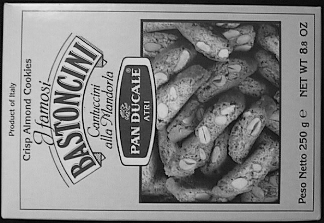

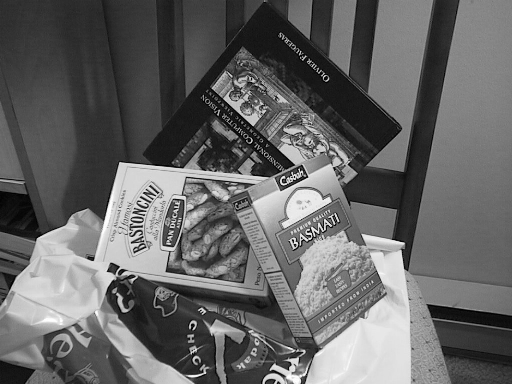

In [184]:
url_path1 = "https://raw.githubusercontent.com/doltonfernandes/CVIT/master/Day4/images/Feature%20Matching/box.png"    
url_path2 = "https://raw.githubusercontent.com/doltonfernandes/CVIT/master/Day4/images/Feature%20Matching/box_in_scene.png"    
I1 = io.imread(url_path1, cv2.IMREAD_GRAYSCALE)
I2 = io.imread(url_path2, cv2.IMREAD_GRAYSCALE)
cv2_imshow(I1)
cv2_imshow(I2)

In [185]:
print(I1[14:17,14:17].reshape((1, 9))[0])

[196 195 198 196 196 199 197 196 198]


In [0]:
# Initiate Sift detector
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1,None)
kp2, des2 = sift.detectAndCompute(I2,None)

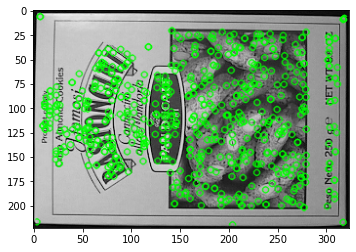

In [187]:
plt.imshow(cv2.drawKeypoints(I1,kp1,None,color=(0,255,0)))

Text(0.5, 0, '(b)')

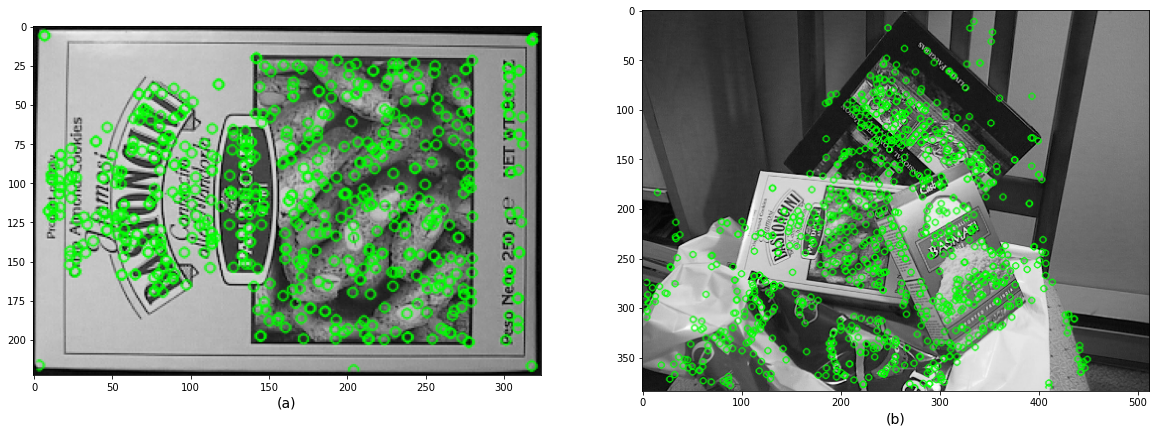

In [188]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(I1,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(I2,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

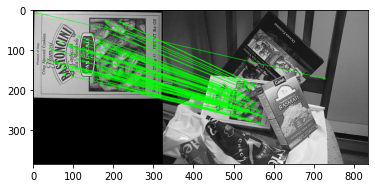

In [189]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(I1,kp1,I2,kp2,good,None,**draw_params)
plt.imshow(img3)

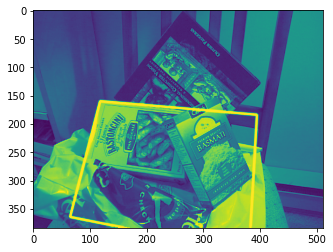

In [190]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = I2.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(I2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    plt.imshow(img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

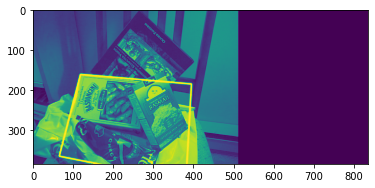

In [191]:
dst = cv2.warpPerspective(I1,M,(I2.shape[1] + I1.shape[1], I2.shape[0]))
dst[0:I2.shape[0],0:I2.shape[1]] = I2
plt.imshow(dst)

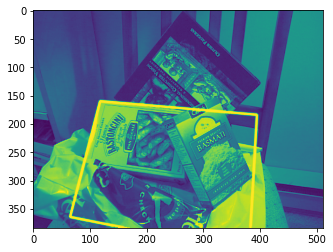

In [192]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop right
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

plt.imshow(trim(dst))

In [0]:
def trim(frame):
          #crop top
          if not np.sum(frame[0]):
              return trim(frame[1:])
          #crop bottom
          if not np.sum(frame[-1]):
              return trim(frame[:-2])
          #crop left
          if not np.sum(frame[:,0]):
              return trim(frame[:,1:])
          #crop right
          if not np.sum(frame[:,-1]):
              return trim(frame[:,:-2])
          return frame

def panorama(path_right,path_left,flag,par=0.9):

      image1=io.imread(path_right)
      if flag:
        image2=path_left
      else:
        image2=io.imread(path_left)

      image1_gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
      image2_gray=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

      image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
      if not flag:
        image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

      cv2_imshow(image1)
      cv2_imshow(image2)

      # Initiate Sift detector
      sift =cv2.xfeatures2d.SIFT_create()
      kp1, des1 = sift.detectAndCompute(image1_gray,None)
      kp2, des2 = sift.detectAndCompute(image2_gray,None)

      # display the keypoints and features detected on both images
      #fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
      #ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
      #ax1.set_xlabel("(a)", fontsize=14)
      #ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
      #ax2.set_xlabel("(b)", fontsize=14)

      match = cv2.BFMatcher()
      matches = match.knnMatch(des1,des2,k=2)

      good = []
      for m,n in matches:
          if m.distance < par*n.distance:
              good.append(m)

      draw_params = dict(matchColor=(0,255,0),
                            singlePointColor=None,
                            flags=2)

      img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
      # plt.imshow(img3)

      MIN_MATCH_COUNT = 10
      if len(good) > MIN_MATCH_COUNT:
          src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
          dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
          h,w = image2_gray.shape
          pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
          dst = cv2.perspectiveTransform(pts, M)
          #img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
          #plt.imshow(img2)
      else:
          print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

      dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]+ image1.shape[0]))
      dst[0:image2.shape[0],0:image2.shape[1]] = image2
      # plt.imshow(dst)

      
      # plt.imshow(trim(dst))
      # cv2.imsave("original_image_stitched_crop.jpg", trim(dst))
      return(trim(dst))

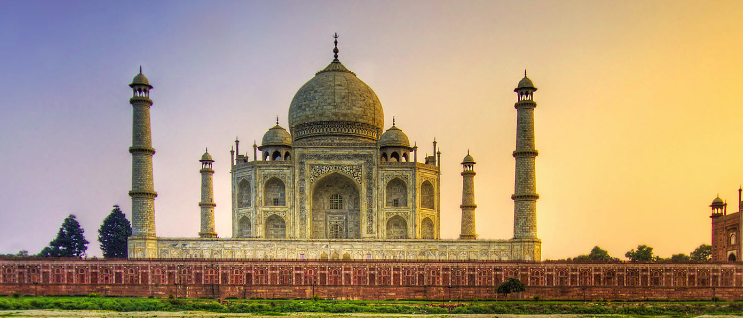

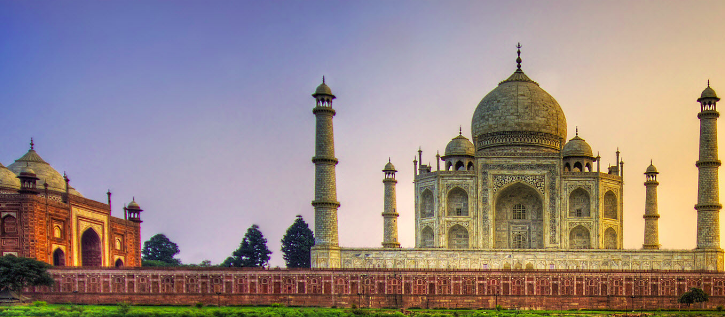

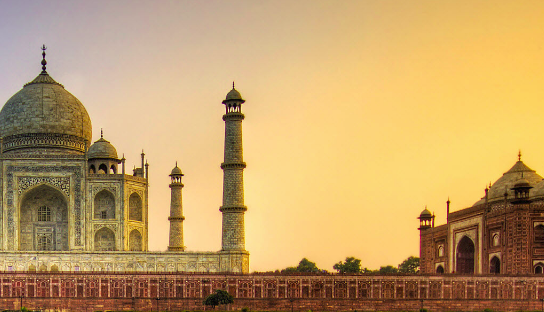

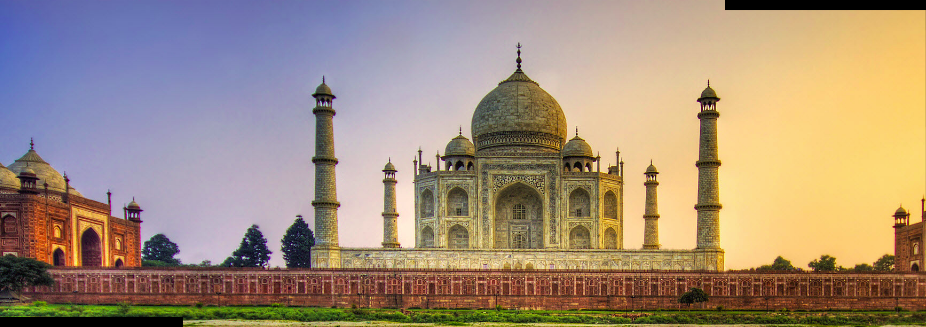

In [194]:
x = panorama('https://raw.githubusercontent.com/doltonfernandes/CVIT/master/Day4/images/Panorama/Eg1/img2_2.png', 'https://raw.githubusercontent.com/doltonfernandes/CVIT/master/Day4/images/Panorama/Eg1/img2_1.png',0)
x = panorama('https://raw.githubusercontent.com/doltonfernandes/CVIT/master/Day4/images/Panorama/Eg1/img2_3.png', x, 1)

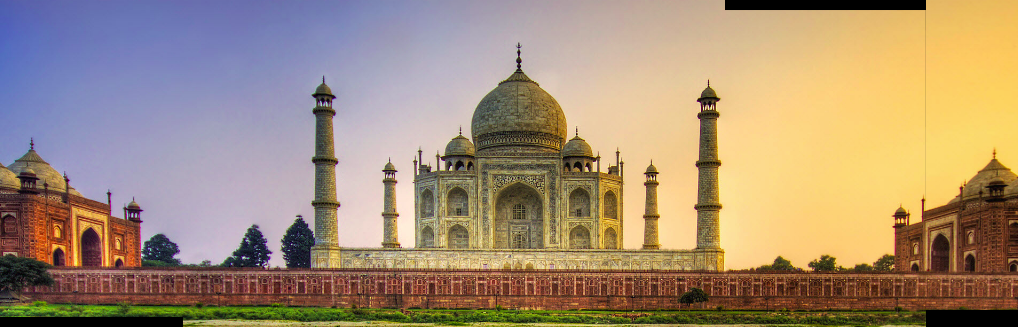

In [195]:
cv2_imshow(x)

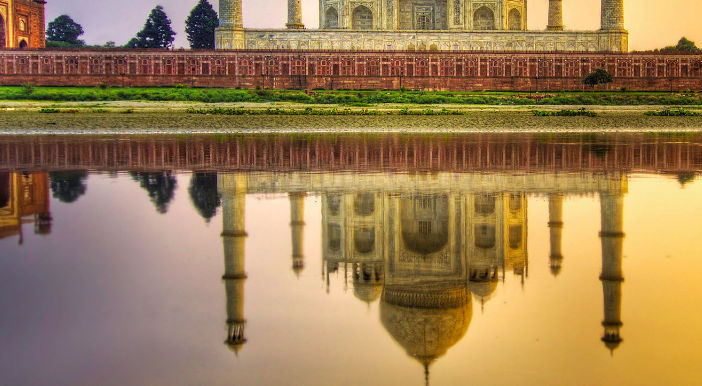

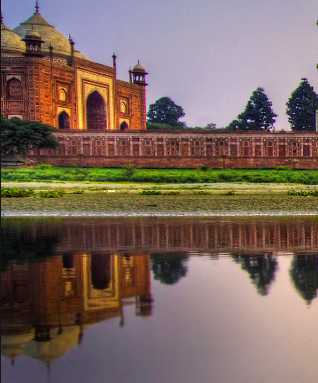

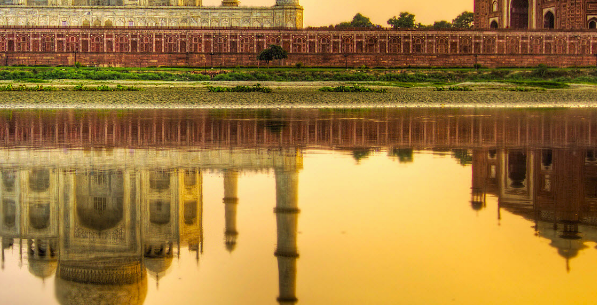

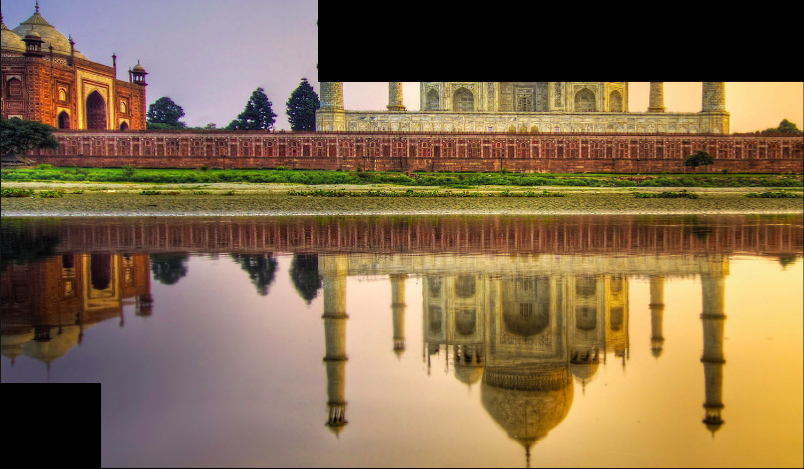

In [196]:
x = panorama('https://raw.githubusercontent.com/doltonfernandes/CVIT/master/Day4/images/Panorama/Eg2/img2_5.png', 'https://raw.githubusercontent.com/doltonfernandes/CVIT/master/Day4/images/Panorama/Eg2/img2_4.png',0)
x = panorama('https://raw.githubusercontent.com/doltonfernandes/CVIT/master/Day4/images/Panorama/Eg2/img2_6.png', x, 1)

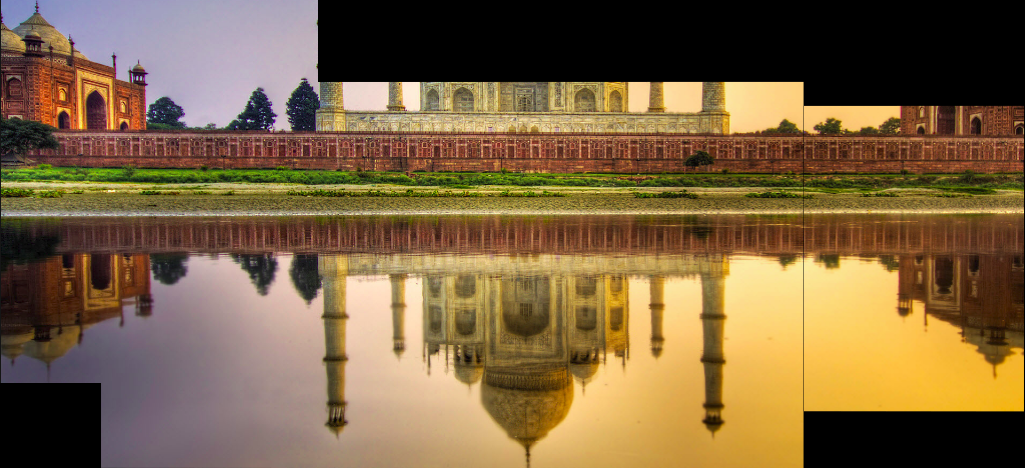

In [197]:
cv2_imshow(x)